<h1 style="text-decoration :underline;color:red"> Comprendre notre modèle </h1>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
test = pd.read_csv('test.csv')

In [2]:
test.head(2)

,Unnamed: 0,PS_C,PS_F,Vainqueur,Prediction,Proba_Challenger,Proba_Favori,proba_PS_Challenger,proba_PS_Favori,gain_theoriq_F,gain_theoriq_C,gain_confiance,pari gagné,cote
0,0,1.090,9.55,challenger,favori,0.468967,0.531033,0.917431,0.104712,5.071361,0.511174,5.071361,0,9.55
1,1,1.126,8.15,challenger,favori,0.434376,0.565624,0.888099,0.122699,4.609839,0.489107,4.609839,0,8.15


<h2 style="text-decoration :underline;color:green">Détection du nombre de matchs sur lesquels parier

<h3>création de la variable gain réel pour connaitre l'évolution du gain selon nombre de paris

In [3]:
test['gain_reel']=0
test['gain_reel']=test["pari gagné"]*test["cote"] -1
test['cumul_gain'] = test['gain_reel'].cumsum()

In [4]:
test.head(2)

,Unnamed: 0,PS_C,PS_F,Vainqueur,Prediction,Proba_Challenger,Proba_Favori,proba_PS_Challenger,proba_PS_Favori,gain_theoriq_F,gain_theoriq_C,gain_confiance,pari gagné,cote,gain_reel,cumul_gain
0,0,1.090,9.55,challenger,favori,0.468967,0.531033,0.917431,0.104712,5.071361,0.511174,5.071361,0,9.55,-1.0,-1.0
1,1,1.126,8.15,challenger,favori,0.434376,0.565624,0.888099,0.122699,4.609839,0.489107,4.609839,0,8.15,-1.0,-2.0


<h3>Gain cumulé en fonction du nombre de pari

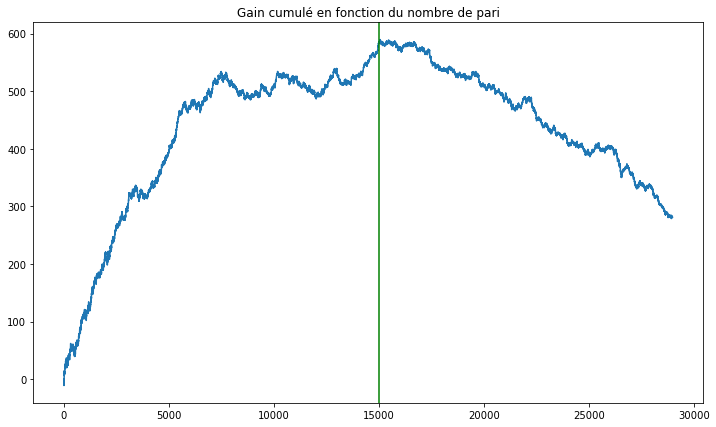

In [5]:
plt.figure(figsize = (12,7))
plt.plot(test.gain_reel.cumsum())
plt.title("Gain cumulé en fonction du nombre de pari")
plt.axvline(x=15000, c="green")
plt.show()

<p>Tout d'abord on regarde le cumul des gains selon le nombre de paris. Et on s'aperçoit que les gains stagnent à partir d'environ 9000 paris. On peut donc fixer un seuil de notre indice de confiance : lorsque l'on est au-dessus, on joue ! On va maintenant chercher la valeur de ce seuil de confiance.<p>

<h3>Seuil de confiance

In [6]:
test[test.cumul_gain==test.cumul_gain.max()]


,Unnamed: 0,PS_C,PS_F,Vainqueur,Prediction,Proba_Challenger,Proba_Favori,proba_PS_Challenger,proba_PS_Favori,gain_theoriq_F,gain_theoriq_C,gain_confiance,pari gagné,cote,gain_reel,cumul_gain
15071,15071,31.0,1.024,favori,favori,0.046966,0.953034,0.032258,0.976562,0.975907,1.45595,0.975907,1,1.024,0.024,589.575


<p>Nous avons pu constater que le cumul maximum des gains dans les 15 000 premières lignes du dataframe est 589 euros, qui représente un seuil de confiance d'environ 0.98.. Autrement dit, si le gain théorique est inférieure à notre mise (1euro), on ne parie plus. On pourrait s'arreter aux 8000 premiers paris vu l'allure de la courbe mais on veut garder un nombre conséquent de pari pour limiter les risques de losing strike et aussi avoir un dataframe assez grand pour l'étude de notre modèle <p>

<h4>Sélection des matchs au dessus du seuil de confiance

In [7]:
test = test[test.gain_confiance >=1]
# test = test.drop('Unnamed: 0', axis = 1)
test.shape

(12580, 16)

<h3> Préparation du dataframe pour l'étude du modèle

<li>Création de 2 dataframes que nous utiliserons dans cette partie

In [8]:
test_pari_gagné = test[test['pari gagné'] == 1]
test_pari_perdu = test[test['pari gagné'] == 0]

challenger_perdu = test[(test.Vainqueur == 'challenger') & (test['pari gagné'] ==0)]
challenger_gagne = test[(test.Vainqueur == 'challenger') & (test['pari gagné'] ==1)]

<li>Création d'une nouvelle colonne : la prédiction du site de pari pour comparer avec notre prédiction

In [9]:
test['pred_ps']= 'wait'
for i in range(len(test)):
    if test.PS_C[i]>test.PS_F[i]:
        test['pred_ps'][i] = 'favori'
    else:
        test['pred_ps'][i] = 'challenger'

<ipython-input-9-37f788e318f4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_ps'][i] = 'challenger'
<ipython-input-9-37f788e318f4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_ps'][i] = 'favori'


<li>découpage en catégories des cotes de paris pour analyser leur impact sur les gains

In [10]:
test['cote_cat']=0
bins = pd.IntervalIndex.from_tuples([(1, 2), (2, 3), (3, 4),(4,5),(5,6),(6,7),(7,200)])
test['cote_cat']= pd.cut(test.cote, bins)

<li>création de la variable pari perdu pour comparer nombre de pari gagné et perdu

In [11]:
test["pari perdu"]=0
test["pari perdu"]= abs(test["pari gagné"]-1)

In [12]:
test.head(1)

,Unnamed: 0,PS_C,PS_F,Vainqueur,Prediction,Proba_Challenger,Proba_Favori,proba_PS_Challenger,proba_PS_Favori,gain_theoriq_F,gain_theoriq_C,gain_confiance,pari gagné,cote,gain_reel,cumul_gain,pred_ps,cote_cat,pari perdu
0,0,1.09,9.55,challenger,favori,0.468967,0.531033,0.917431,0.104712,5.071361,0.511174,5.071361,0,9.55,-1.0,-1.0,challenger,"(7, 200]",1


<h3> Pari gagné en fonction du nombre de match parié

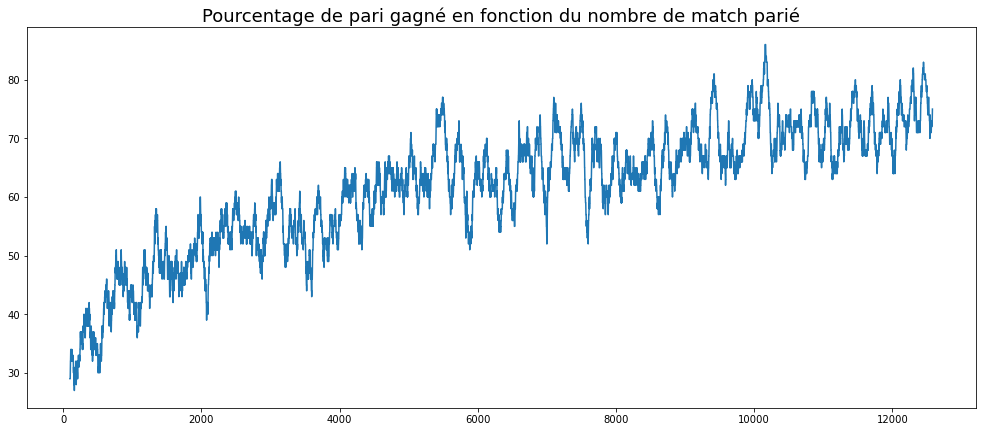

In [13]:
fig, ax1 = plt.subplots(figsize = (17,7))

ax1.plot(test['pari gagné'].rolling(100).apply(sum), )
ax1.tick_params(axis='y')

plt.title('Pourcentage de pari gagné en fonction du nombre de match parié', fontsize = 18);

<p>On observe que le poucentage de pari gagné augmente jusque environ 65% de pari gagné. Mais ces paris étant moins intéressants, le cumul des gains fini par stagner comme on l'a vu précédemment.<p>

<h2 style="text-decoration :underline;color:green">Répartition des paris perdu/gagné en fonction de la cible choisie favori/challenger

In [14]:
pred_perduf = round(len(test[test['pari gagné']==0][test.Prediction == 'favori'])*100 / len(test[['Prediction']]),1)
pred_gagnéf = round(len(test[test['pari gagné']==1][test.Prediction == 'favori'])*100 / len(test[['Prediction']]),1)

pred_perduc = round(len(test[test['pari gagné']==0][test.Prediction == 'challenger'])*100 / len(test[['Prediction']]),1)
pred_gagnéc = round(len(test[test['pari gagné']==1][test.Prediction == 'challenger'])*100 / len(test[['Prediction']]),1)

<ipython-input-14-7fc79c9fe790>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pred_perduf = round(len(test[test['pari gagné']==0][test.Prediction == 'favori'])*100 / len(test[['Prediction']]),1)
<ipython-input-14-7fc79c9fe790>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pred_gagnéf = round(len(test[test['pari gagné']==1][test.Prediction == 'favori'])*100 / len(test[['Prediction']]),1)
<ipython-input-14-7fc79c9fe790>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pred_perduc = round(len(test[test['pari gagné']==0][test.Prediction == 'challenger'])*100 / len(test[['Prediction']]),1)
<ipython-input-14-7fc79c9fe790>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pred_gagnéc = round(len(test[test['pari gagné']==1][test.Prediction == 'challenger'])*100 / len(test[['Prediction']]),1)


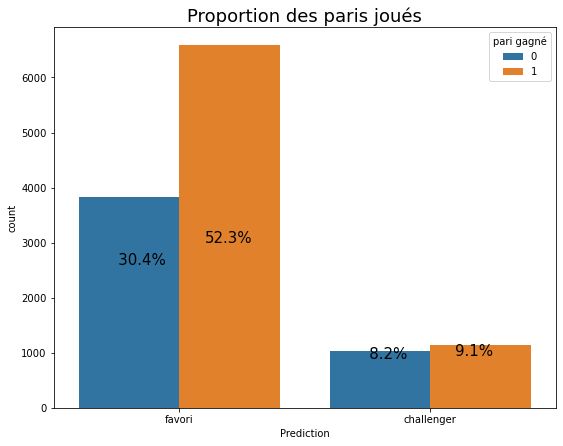

In [15]:
fig, ax1 = plt.subplots(ncols=1, figsize=(9,7), sharey= True)

sns.countplot(x = 'Prediction' , hue = 'pari gagné', data = test, ax = ax1)
ax1.set_title('Proportion des paris joués', fontsize = 18)

plt.annotate(f'   {pred_perduf}%', (-0.3,2600), fontsize = 15)
plt.annotate(f'{pred_gagnéf}%', (0.1,3000), fontsize = 15)

plt.annotate(f'   {pred_perduc}%', (0.7,900), fontsize = 15)
plt.annotate(f'{pred_gagnéc}%', (1.1,950), fontsize = 15);

<p>Sur ce diagramme en barre, on voit que notre algo joue beaucoup sur les favoris. Il en gagne beaucoup (44.6% des paris) mais il en perd aussi beaucoup (33.5%). Il semble sous-évaluer la probabilité des challengers.<p>

In [16]:
pd.crosstab(test.Prediction, test['pari gagné'], normalize = False)

pari gagné,0,1
Prediction,,
challenger,1029,1144
favori,3825,6582


<h2 style="text-decoration :underline;color:green"> Etude des paris par rapport aux favoris/challengers

<h3> Répartition des paris entre favori et challenger

In [17]:
pinnacle_c = round(len(test[test['pred_ps']=='challenger'])*100 / len(test[['pred_ps']]),1)
pinnacle_f = 100 - pinnacle_c

algo_c = round(len(test[test['Prediction']=='challenger'])*100 / len(test[['Prediction']]),1)
algo_f = 100 - algo_c

Resultat_c = round(len(test[test['Vainqueur']=='challenger'])*100 / len(test[['Prediction']]),1)
Resultat_f = 100 - Resultat_c

C:\Users\Anthony\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Anthony\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Anthony\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


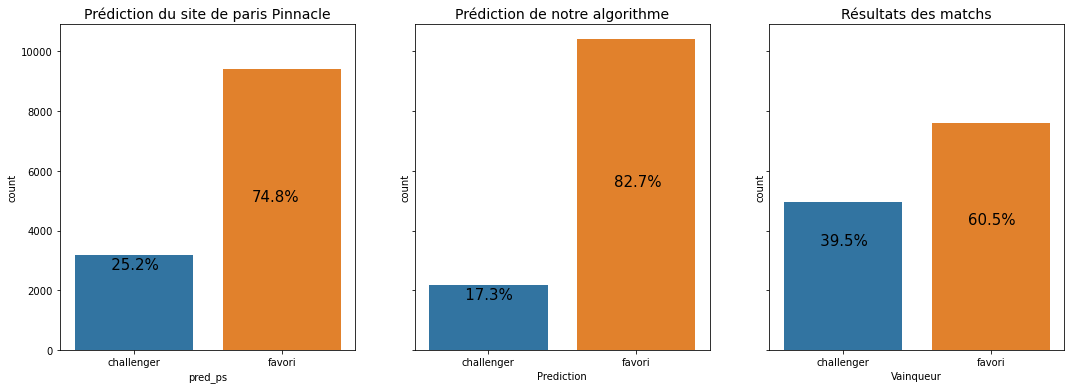

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18,6), sharey= True)
sns.countplot(test['pred_ps'], ax= ax1)
sns.countplot(test['Prediction'], order = ['challenger', 'favori'], ax = ax2)
sns.countplot(test['Vainqueur'], ax = ax3);

ax1.set_title('Prédiction du site de paris Pinnacle', fontsize = 14)
ax2.set_title('Prédiction de notre algorithme', fontsize = 14)
ax3.set_title('Résultats des matchs', fontsize = 14)


ax1.annotate(f'   {pinnacle_c}%', (-0.25,2700), fontsize = 15)
ax1.annotate(f'{pinnacle_f}%', (0.8,5000), fontsize = 15);

ax2.annotate(f'   {algo_c}%', (-0.25,1700), fontsize = 15)
ax2.annotate(f'{algo_f}%', (0.85,5500), fontsize = 15)

ax3.annotate(f'   {Resultat_c}%', (-0.25,3500), fontsize = 15)
ax3.annotate(f'{Resultat_f}%', (0.85,4200), fontsize = 15);

<h3>Gain cumulé des paris en fonction de la cible et du nombre de pari

In [19]:
somme_challenger = round(test[test['Prediction']=='challenger'].gain_reel.sum(),1)
somme_favori = round(test[test['Prediction']=='favori'].gain_reel.sum(),1)

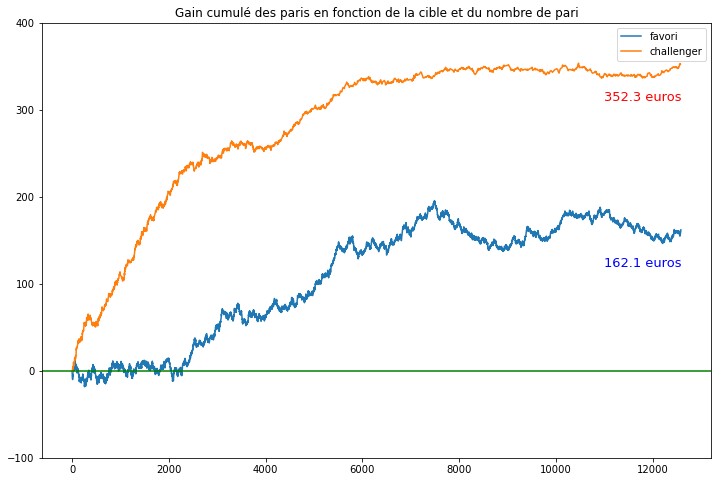

In [28]:
plt.figure(figsize = (12,8))
plt.plot(test[test['Prediction']=='favori'].gain_reel.cumsum(),
         data =test, label = 'favori')

plt.plot(test[test['Prediction']=='challenger'].gain_reel.cumsum(),
         data =test, label = 'challenger')
plt.axhline(y=0, c="green")
plt.ylim(-100,400)
plt.annotate(f'{somme_challenger} euros', (11000, 310), fontsize = 13,color= "red")
plt.annotate(f'{somme_favori} euros', (11000, 120), fontsize = 13, color= "blue")
plt.legend();
plt.title("Gain cumulé des paris en fonction de la cible et du nombre de pari")
plt.show()

<p>Le fait que l'algo parie souvent sur le favoris fait que la somme cumulée des favoris est plus discrète, en effet, avec 33.5% des paris sur le favoris qui ont ratés, l'algo perd aussi plus d'argent en pariant trop sur le favoris.<p>

<h3> Moyenne des gains en fonction de la cible et du nombre de pari

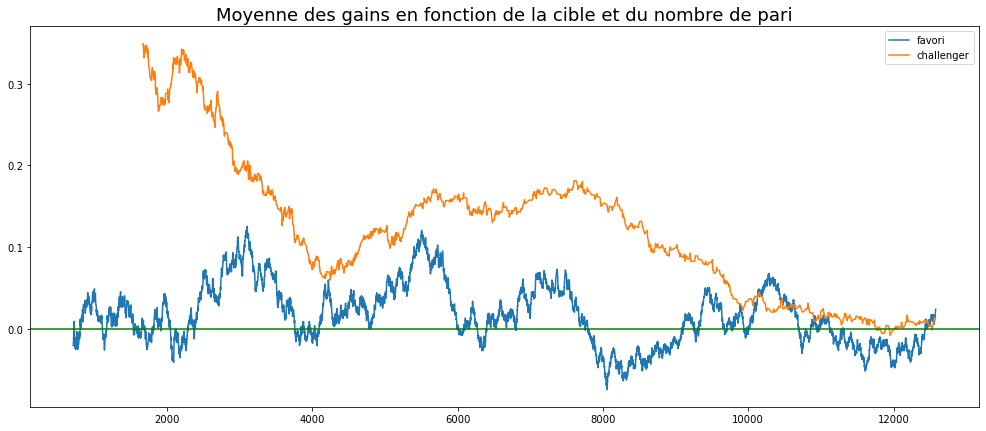

In [21]:
plt.figure(figsize = (17,7))
plt.plot(test[test.Prediction=="favori"]['gain_reel'].rolling(500).mean(),label="favori")
plt.plot(test[test.Prediction=="challenger"]['gain_reel'].rolling(500).mean(),label="challenger")
plt.axhline(y=0, c="green")
plt.title('Moyenne des gains en fonction de la cible et du nombre de pari', fontsize = 18);
plt.legend()
plt.show()

<p>En observant la moyenne des gains/pari il semble plus intéressant de parier sur le challenger. En effet on a vu que le site de pari sous-évalue les performances des challengers, il met donc des côtes élevées pour les challengers. Et lorsque nous gagnons un pari sur un challenger, le gain est plus important. Il est donc plus intéressant de sur-évaluer les performances du challenger de notre algo. On profitera alors de la sous-évaluation du site de pari pour gagner plus de matchs avec des côtes hautes.</p>
<p>On remarque bien qu'après 10000 paris le gain est quasi nul que ce soit pour les favoris ou les challengers.</p>

<h3> Répartition des paris en challenger et favori en suivant notre modèle.

<Figure size 1080x576 with 0 Axes>

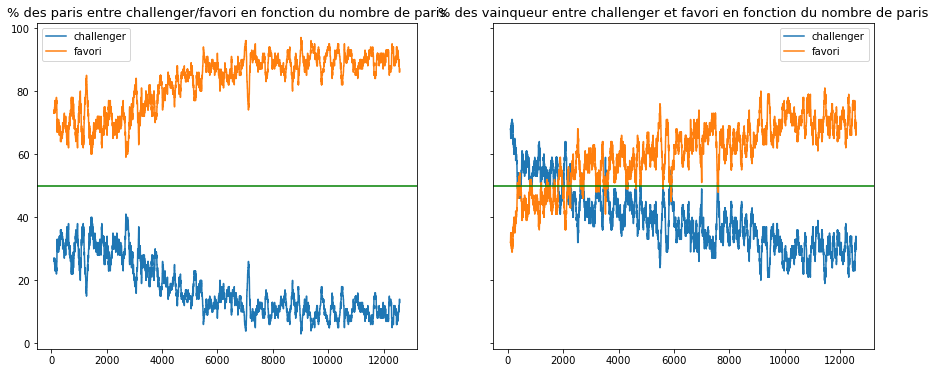

In [22]:
pred = pd.get_dummies(test.Prediction)
vainqueur = pd.get_dummies(test.Vainqueur)
plt.figure(figsize = (15,8))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6), sharey= True)

ax1.plot(pred.challenger.rolling(100).apply(sum), label = 'challenger')
ax1.plot(pred.favori.rolling(100).apply(sum), label = 'favori')
ax1.axhline(y=50, c="green")
ax1.set_title('% des paris entre challenger/favori en fonction du nombre de paris', fontsize = 13)
ax1.legend(title_fontsize = 10);

ax2.plot(vainqueur.challenger.rolling(100).apply(sum), label = 'challenger')
ax2.plot(vainqueur.favori.rolling(100).apply(sum), label = 'favori')
ax2.set_title('% des vainqueur entre challenger et favori en fonction du nombre de paris', fontsize = 13)
ax2.legend(title_fontsize = 10);
ax2.axhline(y=50, c="green")
plt.show()

<p>En comparant les résultats des matchs, on remarque l'algo suit une bonne tendance en pariant de moins en moins sur les challengers, mais parie quand même trop sur les favoris. Il faut rétablir la proportion de paris favori/challenger.

<h2 style="text-decoration :underline;color:green"> Les gains

<h3> Evolution du gain "glissant" sur 200 paris en fonction n-ième pari

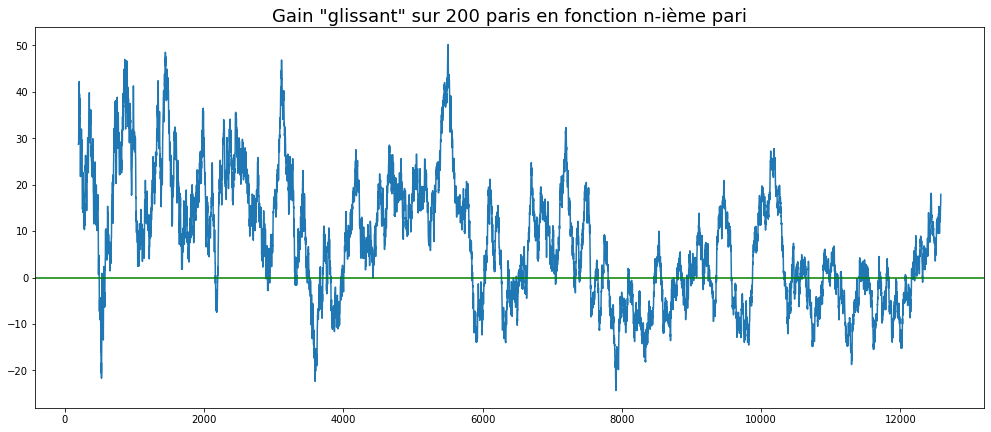

In [23]:
plt.figure(figsize = (17,7))
plt.plot(test['gain_reel'].rolling(200).apply(sum))
plt.axhline(y=0, c="green")
plt.title('Gain "glissant" sur 200 paris en fonction n-ième pari', fontsize = 18);

<p>Globalement, plus on avance dans les paris plus le gain "ponctuel" est faible voire négatif. Malgré des hauts et des bas, on gagne plus d'argent au début (gain confiance élevé) qu'à la fin.</p>
<p>On notera qu'après 8000 paris la gain oscille autour de 0 ce qui est logique au vu de la courbe stable du gain cumulé au niveau de cette zone de pari.</p>

<Figure size 1224x504 with 0 Axes>

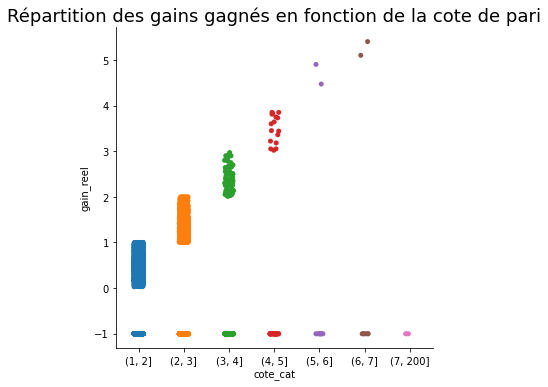

In [24]:
#Distribution des gains en fonction de la cote
plt.figure(figsize = (17,7))
sns.catplot(x="cote_cat",y="gain_reel", data=test)
plt.title('Répartition des gains gagnés en fonction de la cote de pari', fontsize = 18);

          pari gagné  pari perdu
cote_cat                        
(1, 2]          6077        2793
(2, 3]          1525        1769
(3, 4]           104         233
(4, 5]            16          41
(5, 6]             2           9
(6, 7]             2           6
(7, 200]           0           3


<Figure size 1440x1440 with 0 Axes>

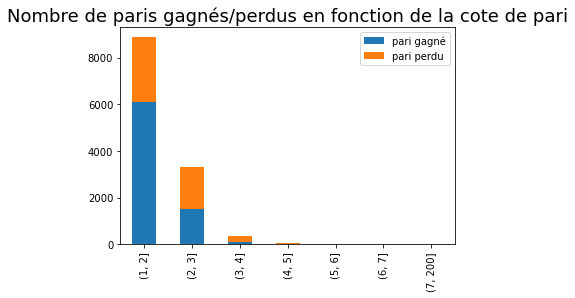

In [25]:
#calcul du nombre de pari gagné et perdu en fonction de la cote
pariGG = test.groupby("cote_cat").agg({"pari gagné":"sum","pari perdu":"sum"})
print(pariGG)

#Graphique en barre du nombre de pari gagné et perdu en fonction de la cote
pariGG = pariGG.reset_index()
fig= plt.figure(figsize=(20,20))
gagne=list(pariGG["pari gagné"])
perdu=list(pariGG["pari perdu"])
index= list(pariGG.cote_cat)
df = pd.DataFrame({'pari gagné': gagne,
                   'pari perdu': perdu}, index=index)
df.plot.bar(stacked=True)
plt.title('Nombre de paris gagnés/perdus en fonction de la cote de pari', fontsize = 18);
plt.show()

On remarque qu'il n'ya pas plus beaucoup de gain pour des cotes supérieur à 4. 

<h2 style="text-decoration :underline;color:green"> Conclusion

<p style="color:blue"> Les paris sur challenger sont essentiels pour augmenter nos gains. Cela s'explique par le fait que les cotes des challengers sont généralement hautes par rapport à celle des favoris.
    Le modèle, malgré 40% de victoire de challenger ne prédit que 17% soit un peu moins de la moitié. Les gains se faisant sur cette cible, il est donc nécessaire de trouver une solution pour appuyer sur la détection des challenger quitte à perdre en détection de favori.

<p style="color:blue">Les features importances données par XGBoost montre que les variables proba elo F et C pèsent très lourd dans le modèle. Cette donnée est difficile à obtenir et de plus elle est fortement liée au rang elo par une formule. Il sera intéressant de tester l'algorithme sans ces 2 variables pour laisser s'exprimer les autres qui pourraient nous permettre de mieux détecter les victoires de challenger.